# Facebook Prophet Time Series Analysis Tutorial

From https://medium.com/swlh/facebook-prophet-426421f7e331/

This notebook using Facebook Prophet to forecast the number of visitors per day to the Peyton Manning Wikipedia page.

The **first model** created is using the **default settings** of Prophet. It provides a good starting point, but misses some key details about the seasonality of the NFL and how that affects search traffic for Manning's Wiki page.

The **second model** created adds in a **logistic growth** configuration as well as adjustment for **US holidays** and displaying **changepoints** where the trend line changes direction.

The **last model** created adds in a self-defined **NFL season filter**, that splits data based on whether it is on-season between September to January or off-season February to August. This **provides the best insight** as it shows how different the search is by day in the off-season versus the on-season. As well, the overall trend line becomes much smoother and gives a better general view of how he is searched. 


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
import matplotlib.dates as mdate

In [17]:
# load the test data from Wikipedia on Peyton Manning
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv')

In [18]:
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [19]:
df.tail()

,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [20]:
df.shape

(2905, 2)

### View the Raw Data

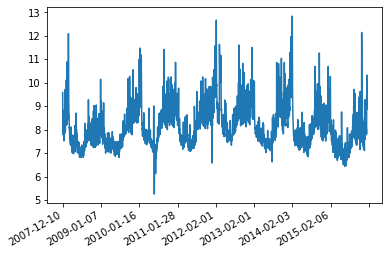

In [21]:
# plot the y values
plt.plot(df['ds'], df['y'])

locator = mdate.YearLocator()

plt.gca().xaxis.set_major_locator(locator)

plt.gcf().autofmt_xdate()

plt.show()

## Create a Model with Default Settings

In [24]:
#instantiate the model
model = Prophet()

# fit the model to the dataframe
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
# make a dataframe for future dates for the next 365 days
future_df = model.make_future_dataframe(periods=365)

# confirm there is an extra year of dates
future_df.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [29]:
# make predictions
forecast_df = model.predict(future_df)
forecast_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-12-10,8.039346,8.197898,9.457130,8.039346,8.039346,0.803277,0.803277,0.803277,0.352299,0.352299,0.352299,0.450978,0.450978,0.450978,0.0,0.0,0.0,8.842622
1,2007-12-11,8.037802,7.994907,9.177585,8.037802,8.037802,0.553349,0.553349,0.553349,0.119636,0.119636,0.119636,0.433714,0.433714,0.433714,0.0,0.0,0.0,8.591151
2,2007-12-12,8.036259,7.826198,9.038962,8.036259,8.036259,0.350724,0.350724,0.350724,-0.066658,-0.066658,-0.066658,0.417383,0.417383,0.417383,0.0,0.0,0.0,8.386983
3,2007-12-13,8.034715,7.747758,8.974157,8.034715,8.034715,0.330166,0.330166,0.330166,-0.072265,-0.072265,-0.072265,0.402430,0.402430,0.402430,0.0,0.0,0.0,8.364881
4,2007-12-14,8.033172,7.751012,8.966099,8.033172,8.033172,0.319694,0.319694,0.319694,-0.069568,-0.069568,-0.069568,0.389262,0.389262,0.389262,0.0,0.0,0.0,8.352865


#### As can be seen above, there are a lot of statistics we get from the Prophet model. All of these statistics can be used to better understand the range expected predictions on different horizons.

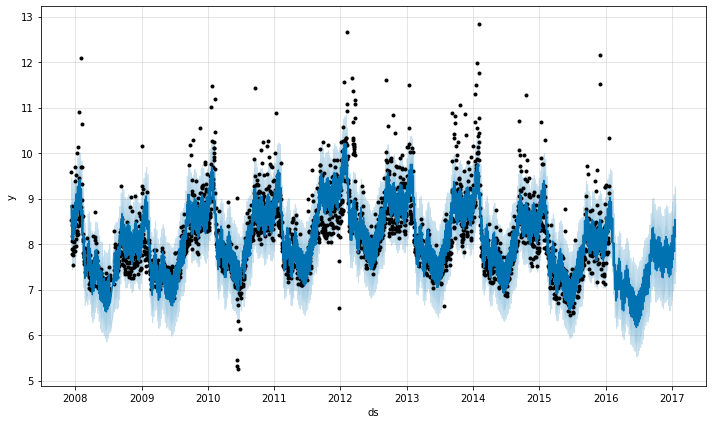

In [30]:
# plot the results of the past data and future forecast
fig1 = model.plot(forecast_df)

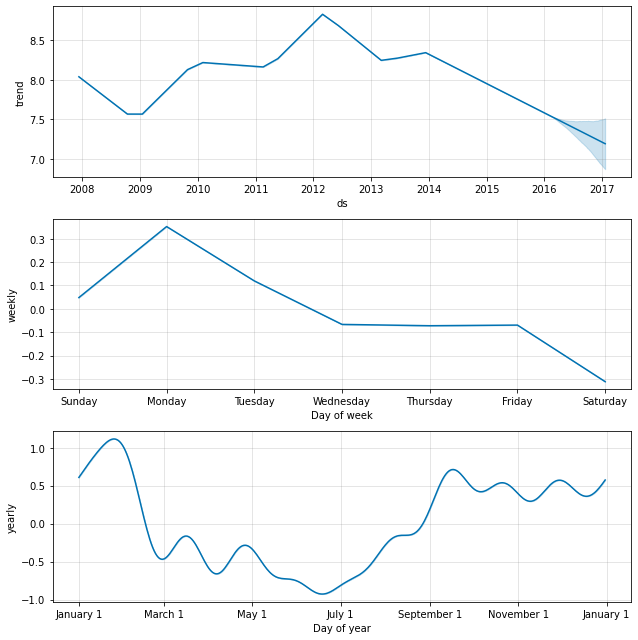

In [31]:
# breakdown the various components
fig2 = model.plot_components(forecast)

### More Obvious Trends:

- Manning's Wikipedia page is searched consistenly at a high leve during the NFL season (September to February) 

- There is a drop-off in searches during the NFL off-season. 

- There are high number of searches during late January to February, which is during the playoffs and the Super Bowl.

### Less Obvious Trends:
- In 2012 there was a spike in searches. Well, according to [Manning's Wikipedia](https://en.wikipedia.org/wiki/Peyton_Manning#2013_season:_Fifth_MVP_and_Super_Bowl_XLVIII_appearance) page, he was released from the Colts on March 2012, which was his team for 13 years.

- In late 2008, there was significantly less activity searching his Wikipedia. During that season, Manning was name NFL MVP. The only explanation I can think of is that the Colts were eliminated from the playoffs in their first game (Wild Card Game). But this also occurred in 2010, which does not show a slight decline. Unfortunately, I do not have a good explanation for this change in the Manning Wikipedia search trend.

- Monday has a higher search than Sunday, my hypothesis that because there is only one NFL game on Monday, if Manning is playing in that game, then all football fans will be likely to search his name. Whereas on Sunday, there are multiple games throughout the day and viewership is split resulting in a high search number, but not a peak number of searches.

- Saturday being the lowest search day. The only rational I can come up with is that football fans are focused on college football that day and do not think much about NFL on that day. Whereas throughout the week they may have a baseline of curiousity about Manning, during Satuday their football attention is mainly taken by college football.

## Use Uncertainty Options and Holiday Options to Improve Forecast



In [32]:
from fbprophet.plot import add_changepoints_to_plot

In [33]:
# set saturation maximum
df['cap'] = 10

# set saturation minimum
df['floor'] = 7 

In [34]:
# create model
uncertainty_model = Prophet(growth='logistic')

In [36]:
# add US holidays for seasonality adjustment
uncertainty_model.add_country_holidays(country_name = 'US')

In [37]:
# fit the model to the data
uncertainty_model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
# create a future dataframe
uncertainty_future = uncertainty_model.make_future_dataframe(periods=365*5)

# set saturation max
uncertainty_future['cap'] = 10

# set saturation mix
uncertainty_future['floor'] = 7

In [39]:
# forecast the future searches
uncertainty_forecast = uncertainty_model.predict(uncertainty_future)

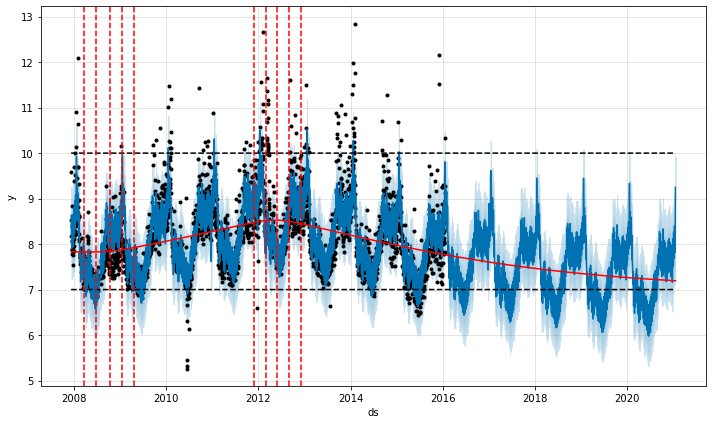

In [42]:
# visualize the forecast
fig1 = uncertainty_model.plot(uncertainty_forecast)

# add change points to the plot
a = add_changepoints_to_plot(fig1.gca(), uncertainty_model, uncertainty_forecast)
plt.show()

### Analysis of the Adjusted Model

By using logistic growth, leveling off points are defined. This creates more realistic forecasting, since linear growth could just keep growing and not hit a saturation point to level off. There are only so many humans on earth and not all of them are going to be interested in Peyton Manning. Thus the max of 10 and min of 7 create a more realistic forecast.

As well, by viewing the changepoints (red dashes), it gives a good indication of when the trend line shifts and can alert of areas of interest to explore why the trend changed at that time period. 

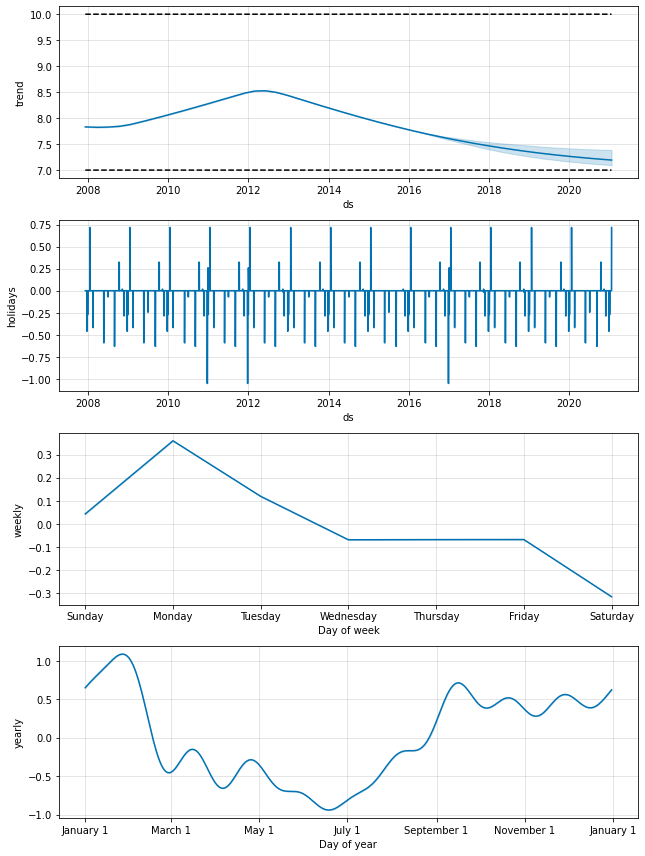

In [45]:
# view the trend components
fig2 = uncertainty_model.plot_components(uncertainty_forecast)
plt.show()

### Analysis of the trends

For the most part the differen trends look like the previous trend plots, but there is a significant change in the first trend plot. It has a smoother shape and might give a more general view of the interest in Peyton Manning through his Wikipedia search. As well, there is no viewable drop-off in his Wikipedia searches in 2009, which was previous not well explained.

The holiday plot shows that most US holidays result in lower Manning Wikipedia traffic, but a few result in a spike. Since the Super Bowl is defined as on the US holidays in Propet, it would likely be that holiday for the largest spike in searches.

## Seasonality Options

Use Conditional Weekly Seasonality on the data


In [46]:
def is_nfl_season(ds):
    
    # convert to datetime
    date = pd.to_datetime(ds)
    
    # if the with September to January, then it is True for the NFL season
    return (date.month > 8 or date.month < 2)

In [47]:
# apply this function to the dataframe and create separate columns for on and off season
df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)

In [48]:
# set user-defined seasonality and fit
season_model = Prophet(weekly_seasonality=False)

# use the nfl season data to add seasonality to the model
season_model.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
season_model.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

# fit the model
season_model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [49]:
# create the future dataframe
season_future = season_model.make_future_dataframe(periods=365*5)

# apply the NFL season to the dataframe
season_future['on_season'] = season_future['ds'].apply(is_nfl_season)
season_future['off_season'] = ~season_future['ds'].apply(is_nfl_season)

In [50]:
# predict the future values
season_forecast = season_model.predict(season_future)

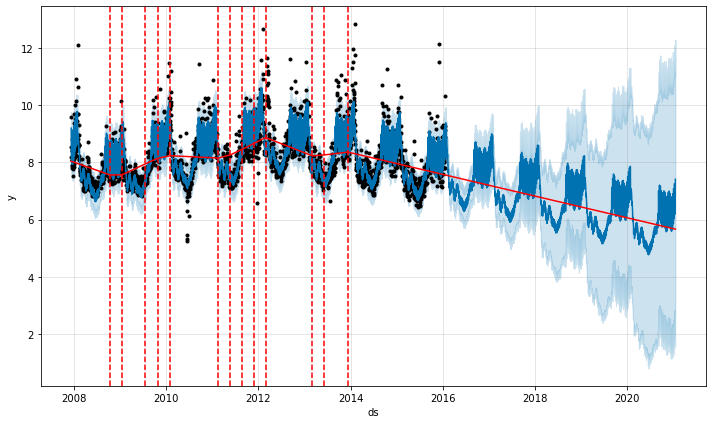

In [51]:
# plot the results
season_fig1 = season_model.plot(season_forecast)
a = add_changepoints_to_plot(season_fig1.gca(), season_model, season_forecast)
plt.show()

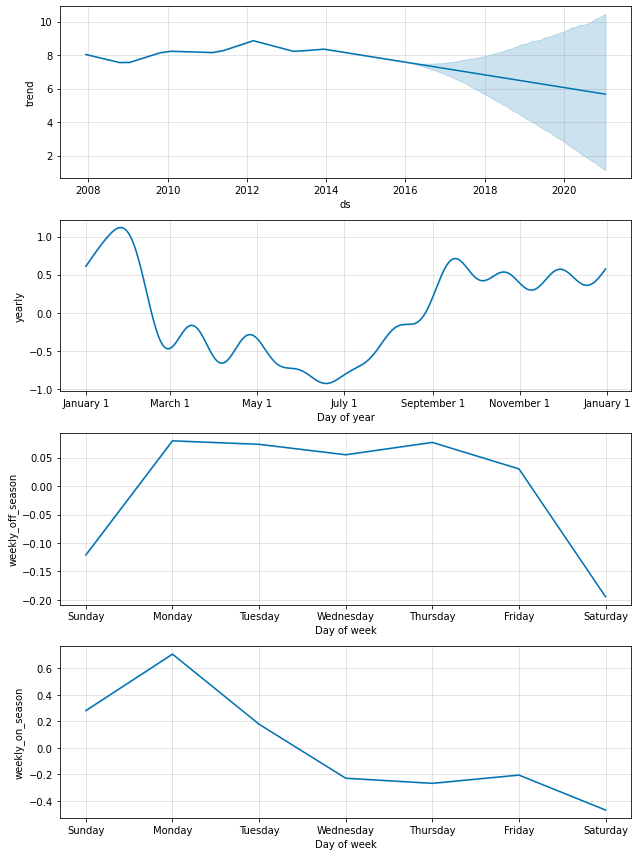

In [53]:
# plot the trend data by component
season_fig2 = season_model.plot_components(season_forecast)
plt.show()

### Splitting the data based on the NFL season leads to a much clearer understanding of the search behavior.

The weekly data is greatly affected by whether it is during the NFL season or after the season has ended. When the NFL season is active, most people search for Petyon Manning's Wikipedia on Sunday or Monday, which are the two days when most NFL games are watched.

When it is out-of-season for the NFL, most of the search activity happens during the week days. Likely because people are at work and might be bored and want to look up random info about popular players. Whereas on the weekends during the off-season they are busy doing other activities.

As well, it smoothed out the first trend plot and shows that there was not much deviation in searching when adjusting the values for whether the NFL season is active or inactive. 

Lastly, we distinctly see that 2014 marks a steady decline in searches. Peyton had already reached his prime, in terms of being an MVP, but he was still playing at a high level and drawing searches. March of 2016 is when Peyton Manning retired from the NFL. From there, the decline is steady as would be expected as people are not watching him actively anymore and not as curious.

### As a Website Provider:
This data allows a website provider to better understand when their might be a larger load on their server and plan resource utilization for expected peaks and lows. Of course, this is just one webpage, but if you host a NFL website with all the players, you would expect similar trends and could partition more resources during the season on Sunday and Monday, while fewer resources on the rest of the week and in the off-season.

### As Peyton Manning's Agent:
This seasonal data can tell you how much your player is in the public's thought process. By using these numbers, better advertising and marketing can be planned to boost his visibility and profitability.